# Selu Demo program
## Use a kaggle playground project as example
#### by Sting Huang
### competition URL
### https://www.kaggle.com/c/plant-seedlings-classification

In [1]:
import tensorflow as tf
from tensorflow.python.framework import ops

print("\nTensorflow version:", tf.__version__)


Tensorflow version: 1.0.0-rc2


# Load data set
## train set has 4630 pictures
## validation set has 120 pictures
## the image was resize from original size to 128*128

In [2]:
from seedingimage import dataset  # user define class

train_db = dataset("train")
valid_db = dataset("validation")

1/12 dataset loaded
2/12 dataset loaded
3/12 dataset loaded
4/12 dataset loaded
5/12 dataset loaded
6/12 dataset loaded
7/12 dataset loaded
8/12 dataset loaded
9/12 dataset loaded
10/12 dataset loaded
11/12 dataset loaded
12/12 dataset loaded
{0: 'Fat Hen', 1: 'Charlock', 2: 'Common wheat', 3: 'Shepherds Purse', 4: 'Maize', 5: 'Scentless Mayweed', 6: 'Loose Silky-bent', 7: 'Common Chickweed', 8: 'Sugar beet', 9: 'Cleavers', 10: 'Small-flowered Cranesbill', 11: 'Black-grass'}
Total data set: 4630 (4630, 3)  time: 49.48357439041138
1/12 dataset loaded
2/12 dataset loaded
3/12 dataset loaded
4/12 dataset loaded
5/12 dataset loaded
6/12 dataset loaded
7/12 dataset loaded
8/12 dataset loaded
9/12 dataset loaded
10/12 dataset loaded
11/12 dataset loaded
12/12 dataset loaded
{0: 'Fat Hen', 1: 'Charlock', 2: 'Common wheat', 3: 'Shepherds Purse', 4: 'Maize', 5: 'Scentless Mayweed', 6: 'Loose Silky-bent', 7: 'Common Chickweed', 8: 'Sugar beet', 9: 'Cleavers', 10: 'Small-flowered Cranesbill', 11:

# Take a look on data

Small-flowered Cranesbill  => [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


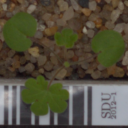

Common Chickweed  => [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


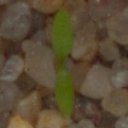

Charlock  => [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


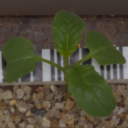

Cleavers  => [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


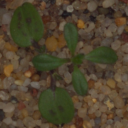

Cleavers  => [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


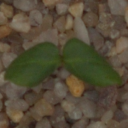

In [7]:
from IPython.core.display import display

images_np , labels, images = train_db.get_images(5)
for img, digitial in zip(images, labels):    
    print(train_db.mapLabel(digitial), " =>", digitial)
    display(img)

# Define Model

In [3]:
import numpy as np

from network import network, layer # user define class

LR = 1e-4
CLASS_NUM = 12
IMG_H = 128
IMG_W = 128

class Model(network):
    
    def __selu(self, inputs, name = None):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        return scale*tf.where(inputs>=0.0, inputs, alpha*tf.nn.elu(inputs))
    
    @layer
    def selu(self, inputs, name = None):
        return self.__selu(inputs, name)
    
    @layer
    def conv2d( self, inputs, mask, out_channel,   strides = [1,1] , relu=True, padding = None, trainable=True, name = None):
        padding = self.padding if padding == None else padding
        self.validate_padding(padding)
        in_channel = inputs.get_shape()[-1]
        assert  in_channel != 0
        convolve = lambda i, k: tf.nn.conv2d(i, k, strides = [1, strides[0], strides[1], 1], padding=padding)
        with tf.variable_scope(name) as scope:
            init_weights = tf.truncated_normal_initializer(0.0, stddev=0.05)
            init_biases = tf.constant_initializer(0.0)
            kernel = self.make_variable('weights', [mask[0], mask[1], in_channel, out_channel], init_weights, trainable)
            biases = self.make_variable('biases', out_channel, init_biases, trainable)
            conv =  convolve(inputs, kernel)
            if relu:
                bias = tf.nn.bias_add(conv, biases)
                return self.__selu(bias, name=scope.name)
            return tf.nn.bias_add(conv, biases, name=scope.name)

    
    def setup(self, autoencoder, name = None):
        assert  name != None
        self.padding = "SAME"
        with tf.variable_scope(name):
            self.image = tf.placeholder(tf.float32, [None, IMG_H,IMG_W, 3], name="image")
            if self.trainable == True: # for test and validation
                self.keep_prob = tf.placeholder(tf.float32)
                self.y_ = tf.placeholder(tf.float32, [None, CLASS_NUM], name="labels")
            (self.feed(self.image )
                .conv2d(mask = [3,3], out_channel = 16, strides = [1,1], name = "l1con1")  #128*128*3 -> 128*128*16
                .conv2d(mask = [3,3], out_channel = 16, strides = [1,1], name = "l1con2")  #128*128*16 -> 128*128*16
                .max_pool(mask = [2,2])  #128*128*16 -> 64*64*16
                .conv2d(mask = [3,3], out_channel = 32, strides = [1,1], name = "l2con1")  #64*64*16 -> 64*64*32
                .conv2d(mask = [3,3], out_channel = 32, strides = [1,1], name = "l2con2")  #64*64*32 -> 64*64*32
                .max_pool(mask = [2,2])  #64*64*32 -> 32*32*32
                .conv2d(mask = [3,3], out_channel = 64, strides = [1,1], name = "l3con1")  #32*32*32 -> 32*32*64
                .makeflat() # 32*32864 -> 65536
                .dropout(keep_prob = self.keep_prob)
                .fc(512, relu = False, trainable = self.trainable, name = "fc1")
                .selu()
                .dropout(keep_prob = self.keep_prob)
                .fc(256, relu = False, trainable = self.trainable, name = "fc2")
                .selu()
                .dropout(keep_prob = self.keep_prob)
                .fc(CLASS_NUM, relu = False, trainable = self.trainable, name = "out")
            )

            self.y = self.get_ouput()
            print( self.y, np.shape(self.y_))
            self.predict_soft =  tf.nn.softmax(self.y, name = "soft")
            self.predict = tf.argmax(self.y, axis = 1, name = "predict")
            if self.trainable == True: # for test and validation
                self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits( labels = self.y_, logits = self.y,  name='loss_'), name = "loss")
                correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
                self.accuracy= tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                self.trainStep =  tf.train.AdamOptimizer(LR, name = "train_opt").minimize(self.cost)

# Train Model

In [4]:
ops.reset_default_graph()  #< ==== reset everything
net = Model(name= "CNN")
SAVE = "save/selu.ckpt"
KEEP_PROB = 0.5
echo = 0
patient = 15
best_acc = 0
best_valid_acc = 0
best_step = 0
saver = tf.train.Saver()
training_process = []
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
while(True):
    echo += 1
    x_, y_ = train_db.get_batch(32)
    feed_dict = {net.image: x_, net.y_: y_, net.keep_prob: KEEP_PROB}
    sess.run(net.trainStep, feed_dict = feed_dict)
    if echo % 50 == 0:
        x_, y_ = train_db.get_batch(128)
        feed_dict = {net.image: x_, net.y_: y_, net.keep_prob: 1}
        cost, acc = sess.run( (net.cost, net.accuracy), feed_dict = feed_dict)
        x_, y_ = valid_db.get_batch(120)
        feed_dict = {net.image: x_, net.y_: y_, net.keep_prob: 1}
        valid_cost, valid_acc = sess.run( (net.cost, net.accuracy), feed_dict = feed_dict)
        print("Step:{0}, training cost:{1:.3f}, accuracy:{2:.3f}, validation cost:{3:.3f}, accuracy:{4:.3f}".format( echo, cost, acc, valid_cost,valid_acc))
        training_process.append([acc, valid_acc])
        patient -= 1
        if best_acc < acc:
            best_acc = acc
            best_valid_acc = valid_acc
            patient = 10
            best_step = echo
            print(saver.save(sess, SAVE, global_step = echo))
    if patient <= 0:
        print("Early stop on step {0} with accuracy:{1:.3f} and validation accuracy:{2:.3f}".format( best_step, best_acc, best_valid_acc))
        break

Tensor("CNN/out/CNN/out:0", shape=(?, 12), dtype=float32) (?, 12)
Step:50, training cost:2.193, accuracy:0.273, validation cost:2.307, accuracy:0.167
save/selu.ckpt-50
Step:100, training cost:1.698, accuracy:0.406, validation cost:1.805, accuracy:0.350
save/selu.ckpt-100
Step:150, training cost:1.385, accuracy:0.492, validation cost:1.399, accuracy:0.517
save/selu.ckpt-150
Step:200, training cost:1.252, accuracy:0.633, validation cost:1.220, accuracy:0.600
save/selu.ckpt-200
Step:250, training cost:1.146, accuracy:0.633, validation cost:1.091, accuracy:0.633
Step:300, training cost:0.955, accuracy:0.664, validation cost:1.039, accuracy:0.692
save/selu.ckpt-300
Step:350, training cost:0.897, accuracy:0.727, validation cost:0.960, accuracy:0.675
save/selu.ckpt-350
Step:400, training cost:0.592, accuracy:0.852, validation cost:0.904, accuracy:0.692
save/selu.ckpt-400
Step:450, training cost:0.814, accuracy:0.719, validation cost:1.001, accuracy:0.692
Step:500, training cost:0.697, accurac

# Plot the traninig process

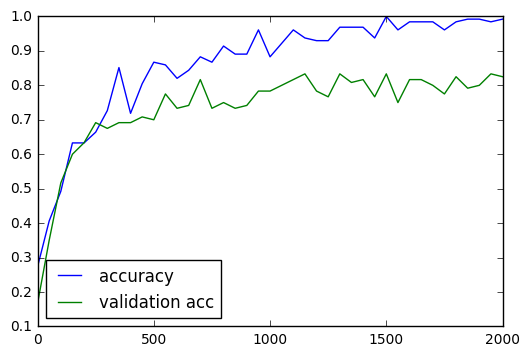

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame(training_process,index=np.arange(len(training_process)*50, step =50), columns =['accuracy','validation acc'])
data.plot()
plt.show()

# Check result

Successfully loaded: save/selu.ckpt-1550
actually => predict result: Sugar beet  =>  Sugar beet


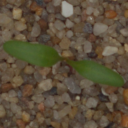

actually => predict result: Small-flowered Cranesbill  =>  Small-flowered Cranesbill


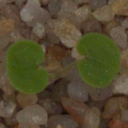

actually => predict result: Common Chickweed  =>  Common Chickweed


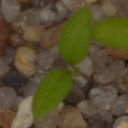

actually => predict result: Small-flowered Cranesbill  =>  Small-flowered Cranesbill


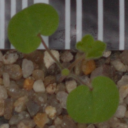

actually => predict result: Scentless Mayweed  =>  Scentless Mayweed


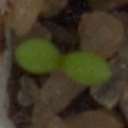

In [8]:
net.loadsavedstate(sess, None)
x_, y_, images = valid_db.get_images(5)
feed_dict = {net.image: x_, net.y_: y_, net.keep_prob: 1}
predict = sess.run( (net.predict), feed_dict = feed_dict)
for img, digitial_, digitial in zip(images, y_, predict):
    label_oh = np.zeros((CLASS_NUM,))
    label_oh[digitial] = 1
    print( "actually => predict result:", train_db.mapLabel(digitial_), " => ", train_db.mapLabel(label_oh))
    display(img)    

# Take a look on feature map
## Side by side compares the feature map between difference image

source image


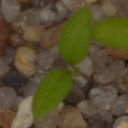

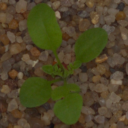

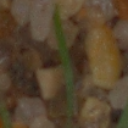

feature map of l1con0


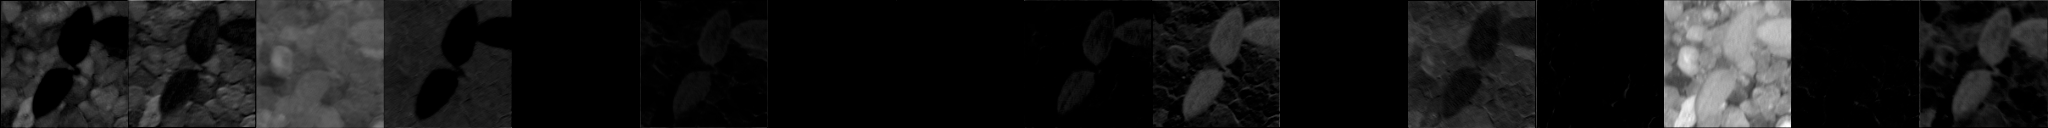

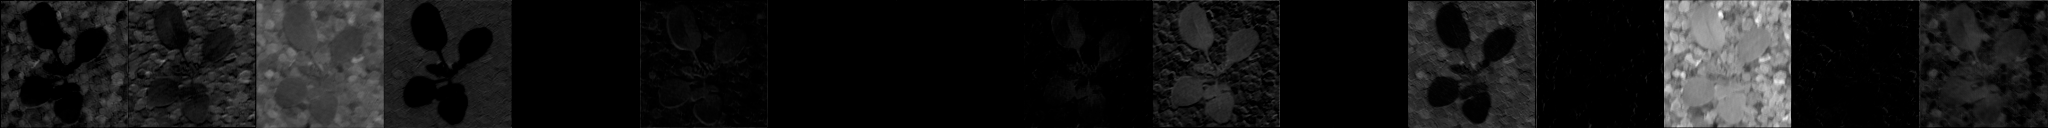

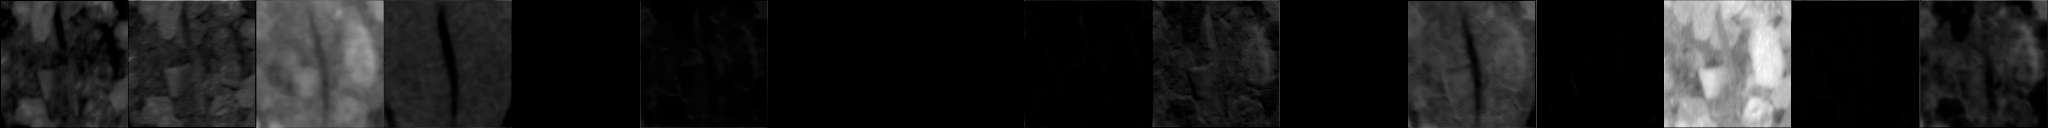

feature map of l2con0


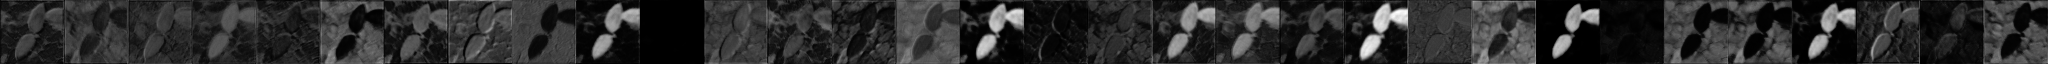

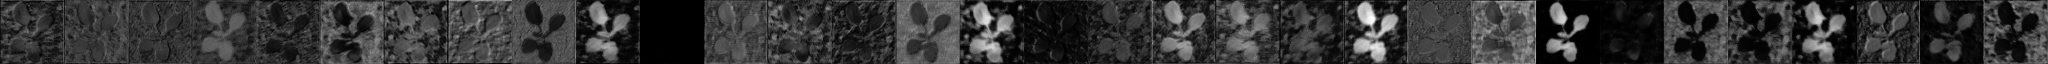

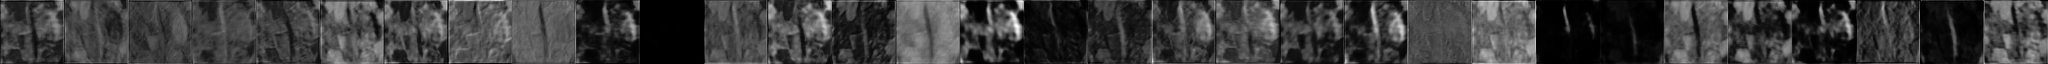

feature map of l3con0


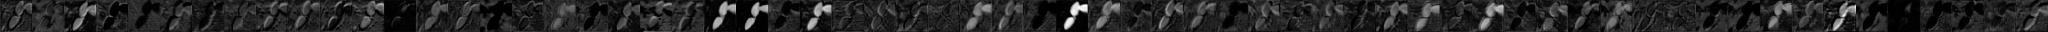

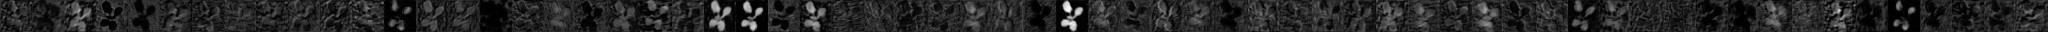

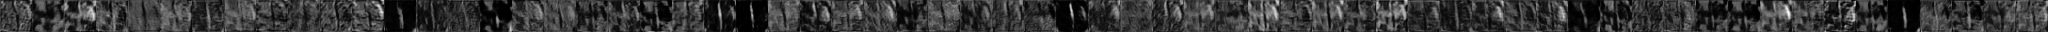

In [9]:
from scipy.misc.pilutil import toimage

x_, y_, images = valid_db.get_images(3)
feed_dict = {net.image: x_, net.y_: y_, net.keep_prob: 1}
l1con0, l2con0, l3con0 = sess.run( (net.feedlayer[-16], net.feedlayer[-13], net.feedlayer[-10]), feed_dict = feed_dict)

print("source image")
for img in images:
    display(img)

print("feature map of l1con0")
for img_idx in range(3):
    l1 = l1con0[img_idx,:,:,0]
    for layer in range(1,  np.shape(l1con0)[3]):
        l1 = np.concatenate((l1[:,:], l1con0[img_idx,:,:,layer]), axis = 1)
    display(toimage(l1))

print("feature map of l2con0")
for img_idx in range(3):
    l2 = l2con0[img_idx,:,:,0]
    for layer in range(1,  np.shape(l2con0)[3]):
        l2 = np.concatenate((l2[:,:], l2con0[img_idx,:,:,layer]), axis = 1)
    display(toimage(l2))    

print("feature map of l3con0")    
for img_idx in range(3):
    l3 = l3con0[img_idx,:,:,0]
    for layer in range(1,  np.shape(l3con0)[3]):
        l3 = np.concatenate((l3[:,:], l3con0[img_idx,:,:,layer]), axis = 1)
    display(toimage(l3))

In [3]:
import numpy as np

from network import network, layer # user define class

LR = 1e-4
CLASS_NUM = 12
IMG_H = 128
IMG_W = 128

class Model_2(network):
    
    def __selu(self, inputs, name = None):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        return scale*tf.where(inputs>=0.0, inputs, alpha*tf.nn.elu(inputs))
    
    @layer
    def selu(self, inputs, name = None):
        return self.__selu(inputs, name)
    
    @layer
    def conv2d( self, inputs, mask, out_channel,   strides = [1,1] , relu=True, padding = None, trainable=True, name = None):
        padding = self.padding if padding == None else padding
        self.validate_padding(padding)
        in_channel = inputs.get_shape()[-1]
        assert  in_channel != 0
        convolve = lambda i, k: tf.nn.conv2d(i, k, strides = [1, strides[0], strides[1], 1], padding=padding)
        with tf.variable_scope(name) as scope:
            #init_weights = tf.truncated_normal_initializer(0.0, stddev= np.sqrt(1.0 /int(in_channel*9)))
            init_weights = tf.truncated_normal_initializer(0.0, stddev=0.05)
            init_biases = tf.constant_initializer(0.0)
            kernel = self.make_variable('weights', [mask[0], mask[1], in_channel, out_channel], init_weights, trainable)
            biases = self.make_variable('biases', out_channel, init_biases, trainable)
            conv =  convolve(inputs, kernel)
            if relu:
                bias = tf.nn.bias_add(conv, biases)
                return self.__selu(bias, name=scope.name)
            return tf.nn.bias_add(conv, biases, name=scope.name)
    
    def setup(self, autoencoder, name = None):
        assert  name != None
        self.padding = "SAME"
        with tf.variable_scope(name):
            self.image = tf.placeholder(tf.float32, [None, IMG_H,IMG_W, 3], name="image")
            if self.trainable == True: # for test and validation
                self.keep_prob = tf.placeholder(tf.float32)
                self.y_ = tf.placeholder(tf.float32, [None, CLASS_NUM], name="labels")
            (self.feed(self.image )
                #.batch_norm(phase = (self.keep_prob != 1))
                .conv2d(mask = [3,3], out_channel = 16, strides = [1,1], name = "l1con1")  #128*128*3 -> 128*128*16
                .conv2d(mask = [3,3], out_channel = 16, strides = [1,1], name = "l1con2")  #128*128*16 -> 128*128*16
                .max_pool(mask = [2,2])  #128*128*16 -> 64*64*16
                .conv2d(mask = [3,3], out_channel = 32, strides = [1,1], name = "l2con1")  #64*64*16 -> 64*64*32
                .conv2d(mask = [3,3], out_channel = 32, strides = [1,1], name = "l2con2")  #64*64*32 -> 64*64*32
                .max_pool(mask = [2,2])  #64*64*32 -> 32*32*32
                .conv2d(mask = [3,3], out_channel = 64, strides = [1,1], name = "l3con1")  #32*32*32 -> 32*32*64
                .conv2d(mask = [3,3], out_channel = 64, strides = [1,1], name = "l3con2")  #32*32*32 -> 32*32*64
                .conv2d(mask = [3,3], out_channel = 64, strides = [1,1], name = "l3con3")  #32*32*32 -> 32*32*64
                .max_pool(mask = [2,2])  #32*32*64 -> 16*16*64
                .conv2d(mask = [3,3], out_channel = 128, strides = [1,1], name = "l4con1")  #16*16*64 -> 16*16*128
                .conv2d(mask = [3,3], out_channel = 128, strides = [1,1], name = "l4con2")  #16*16*64 -> 16*16*128
                .conv2d(mask = [3,3], out_channel = 128, strides = [1,1], name = "l4con3")  #16*16*64 -> 16*16*128
                .max_pool(mask = [2,2])  #16*16*128 -> 4*4*128
                .makeflat() # 4*4*128 -> 2048
                .dropout(keep_prob = self.keep_prob)
                .fc(512, relu = False, trainable = self.trainable, name = "fc1")
                 .selu()
                .dropout(keep_prob = self.keep_prob)
                .fc(256, relu = False, trainable = self.trainable, name = "fc2")
                 .selu()
                .dropout(keep_prob = self.keep_prob)
                .fc(CLASS_NUM, relu = False, trainable = self.trainable, name = "out")
            )

            self.y = self.get_ouput()
            print( self.y, np.shape(self.y_))
            self.predict_soft =  tf.nn.softmax(self.y, name = "soft")
            self.predict = tf.argmax(self.y, axis = 1, name = "predict")
            if self.trainable == True: # for test and validation
                self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits( labels = self.y_, logits = self.y,  name='loss_'), name = "loss")
                correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
                self.accuracy= tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                self.trainStep =  tf.train.AdamOptimizer(LR, name = "train_opt").minimize(self.cost)

In [4]:
ops.reset_default_graph()  #< ==== reset everything
net = Model_2(name= "selu")
SAVE = "save/selu.ckpt"
KEEP_PROB = 0.8
echo = 0
best_acc = 0
best_valid_acc = 0
best_step = 0
saver = tf.train.Saver()
training_process_2 = []
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for echo in range(2000):
    x_, y_ = train_db.get_batch(32)
    feed_dict = {net.image: x_, net.y_: y_, net.keep_prob: KEEP_PROB}
    sess.run(net.trainStep, feed_dict = feed_dict)
    if echo % 50 == 0:
        x_, y_ = train_db.get_batch(128)
        feed_dict = {net.image: x_, net.y_: y_, net.keep_prob: 1}
        cost, acc = sess.run( (net.cost, net.accuracy), feed_dict = feed_dict)
        x_, y_ = valid_db.get_batch(120)
        feed_dict = {net.image: x_, net.y_: y_, net.keep_prob: 1}
        valid_cost, valid_acc = sess.run( (net.cost, net.accuracy), feed_dict = feed_dict)
        print("Step:{0}, training cost:{1:.3f}, accuracy:{2:.3f}, validation cost:{3:.3f}, accuracy:{4:.3f}".format( echo, cost, acc, valid_cost,valid_acc))
        training_process_2.append([acc, valid_acc])        
        if best_acc < acc:
            best_acc = acc
            best_valid_acc = valid_acc            
            best_step = echo
            print(saver.save(sess, SAVE, global_step = echo))
print("Best on step {0} with accuracy:{1:.3f} and validation accuracy:{2:.3f}".format( best_step, best_acc, best_valid_acc))        

Tensor("selu/out/selu/out:0", shape=(?, 12), dtype=float32) (?, 12)
Step:0, training cost:2.445, accuracy:0.164, validation cost:2.503, accuracy:0.083
save/selu.ckpt-0
Step:50, training cost:1.955, accuracy:0.336, validation cost:2.109, accuracy:0.258
save/selu.ckpt-50
Step:100, training cost:1.532, accuracy:0.477, validation cost:1.679, accuracy:0.367
save/selu.ckpt-100
Step:150, training cost:1.417, accuracy:0.484, validation cost:1.510, accuracy:0.350
save/selu.ckpt-150
Step:200, training cost:1.312, accuracy:0.508, validation cost:1.205, accuracy:0.550
save/selu.ckpt-200
Step:250, training cost:0.855, accuracy:0.719, validation cost:1.004, accuracy:0.633
save/selu.ckpt-250
Step:300, training cost:0.864, accuracy:0.750, validation cost:0.822, accuracy:0.708
save/selu.ckpt-300
Step:350, training cost:0.717, accuracy:0.719, validation cost:0.940, accuracy:0.725
Step:400, training cost:0.568, accuracy:0.781, validation cost:0.848, accuracy:0.733
save/selu.ckpt-400
Step:450, training co

In [5]:
import numpy as np

from network import network, layer # user define class

LR = 1e-4
CLASS_NUM = 12
IMG_H = 128
IMG_W = 128

class Model_relu(network):       
    def setup(self, autoencoder, name = None):
        assert  name != None
        self.padding = "SAME"
        with tf.variable_scope(name):
            self.image = tf.placeholder(tf.float32, [None, IMG_H,IMG_W, 3], name="image")
            if self.trainable == True: # for test and validation
                self.keep_prob = tf.placeholder(tf.float32)
                self.y_ = tf.placeholder(tf.float32, [None, CLASS_NUM], name="labels")
            (self.feed(self.image )
                #.batch_norm(phase = (self.keep_prob != 1))
                .conv2d(mask = [3,3], out_channel = 16, strides = [1,1], name = "l1con1")  #128*128*3 -> 128*128*16
                .conv2d(mask = [3,3], out_channel = 16, strides = [1,1], name = "l1con2")  #128*128*16 -> 128*128*16
                .max_pool(mask = [2,2])  #128*128*16 -> 64*64*16
                .conv2d(mask = [3,3], out_channel = 32, strides = [1,1], name = "l2con1")  #64*64*16 -> 64*64*32
                .conv2d(mask = [3,3], out_channel = 32, strides = [1,1], name = "l2con2")  #64*64*32 -> 64*64*32
                .max_pool(mask = [2,2])  #64*64*32 -> 32*32*32
                .conv2d(mask = [3,3], out_channel = 64, strides = [1,1], name = "l3con1")  #32*32*32 -> 32*32*64
                .conv2d(mask = [3,3], out_channel = 64, strides = [1,1], name = "l3con2")  #32*32*32 -> 32*32*64
                .conv2d(mask = [3,3], out_channel = 64, strides = [1,1], name = "l3con3")  #32*32*32 -> 32*32*64
                .max_pool(mask = [2,2])  #32*32*64 -> 16*16*64
                .conv2d(mask = [3,3], out_channel = 128, strides = [1,1], name = "l4con1")  #16*16*64 -> 16*16*128
                .conv2d(mask = [3,3], out_channel = 128, strides = [1,1], name = "l4con2")  #16*16*64 -> 16*16*128
                .conv2d(mask = [3,3], out_channel = 128, strides = [1,1], name = "l4con3")  #16*16*64 -> 16*16*128
                .max_pool(mask = [2,2])  #16*16*128 -> 4*4*128
                .makeflat() # 4*4*128 -> 2048
                .dropout(keep_prob = self.keep_prob)
                .fc(512, relu = True, trainable = self.trainable, name = "fc1")                 
                .dropout(keep_prob = self.keep_prob)
                .fc(256, relu = True, trainable = self.trainable, name = "fc2")                 
                .dropout(keep_prob = self.keep_prob)
                .fc(CLASS_NUM, relu = False, trainable = self.trainable, name = "out")
            )

            self.y = self.get_ouput()
            print( self.y, np.shape(self.y_))
            self.predict_soft =  tf.nn.softmax(self.y, name = "soft")
            self.predict = tf.argmax(self.y, axis = 1, name = "predict")
            if self.trainable == True: # for test and validation
                self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits( labels = self.y_, logits = self.y,  name='loss_'), name = "loss")
                correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
                self.accuracy= tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                self.trainStep =  tf.train.AdamOptimizer(LR, name = "train_opt").minimize(self.cost)

In [7]:
ops.reset_default_graph()  #< ==== reset everything
net = Model_relu(name= "selu")
SAVE = "save/selu.ckpt"
KEEP_PROB = 0.8
echo = 0
best_acc = 0
best_valid_acc = 0
best_step = 0
saver = tf.train.Saver()
training_process = []
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for echo in range(2000):
    x_, y_ = train_db.get_batch(32)
    feed_dict = {net.image: x_, net.y_: y_, net.keep_prob: KEEP_PROB}
    sess.run(net.trainStep, feed_dict = feed_dict)
    if echo % 50 == 0:
        x_, y_ = train_db.get_batch(128)
        feed_dict = {net.image: x_, net.y_: y_, net.keep_prob: 1}
        cost, acc = sess.run( (net.cost, net.accuracy), feed_dict = feed_dict)
        x_, y_ = valid_db.get_batch(120)
        feed_dict = {net.image: x_, net.y_: y_, net.keep_prob: 1}
        valid_cost, valid_acc = sess.run( (net.cost, net.accuracy), feed_dict = feed_dict)
        print("Step:{0}, training cost:{1:.3f}, accuracy:{2:.3f}, validation cost:{3:.3f}, accuracy:{4:.3f}".format( echo, cost, acc, valid_cost,valid_acc))
        training_process.append([acc, valid_acc])
        if best_acc < acc:
            best_acc = acc
            best_valid_acc = valid_acc            
            best_step = echo
            print(saver.save(sess, SAVE, global_step = echo))
print("Best on step {0} with accuracy:{1:.3f} and validation accuracy:{2:.3f}".format( best_step, best_acc, best_valid_acc))        

Tensor("selu/out/selu/out:0", shape=(?, 12), dtype=float32) (?, 12)
Step:0, training cost:2.485, accuracy:0.086, validation cost:2.485, accuracy:0.083
save/selu.ckpt-0
Step:50, training cost:2.470, accuracy:0.141, validation cost:2.565, accuracy:0.083
save/selu.ckpt-50
Step:100, training cost:2.455, accuracy:0.125, validation cost:2.508, accuracy:0.083
Step:150, training cost:2.428, accuracy:0.141, validation cost:2.572, accuracy:0.083
Step:200, training cost:2.216, accuracy:0.234, validation cost:2.496, accuracy:0.092
save/selu.ckpt-200
Step:250, training cost:1.941, accuracy:0.328, validation cost:2.156, accuracy:0.233
save/selu.ckpt-250
Step:300, training cost:1.603, accuracy:0.445, validation cost:1.903, accuracy:0.283
save/selu.ckpt-300
Step:350, training cost:1.546, accuracy:0.445, validation cost:1.821, accuracy:0.300
Step:400, training cost:1.506, accuracy:0.391, validation cost:1.717, accuracy:0.367
Step:450, training cost:1.328, accuracy:0.562, validation cost:1.606, accuracy

==== selu ====


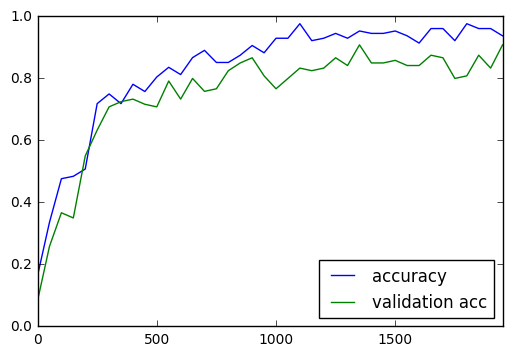

====  relu  ====


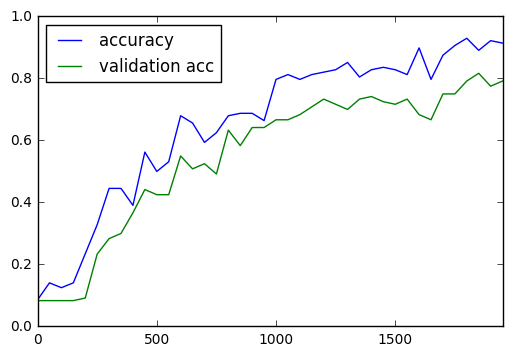

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

print("==== selu ====")
data = pd.DataFrame(training_process_2,index=np.arange(len(training_process_2)*50, step =50), columns =['accuracy','validation acc'])
data.plot()
plt.show()

print("====  relu  ====")
data = pd.DataFrame(training_process,index=np.arange(len(training_process)*50, step =50), columns =['accuracy','validation acc'])
data.plot()
plt.show()